In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
from keras.optimizers import SGD
import h5py
import numpy as np
import keras
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.applications as App
from keras import backend as K
from keras.layers import Input, Activation
from keras.layers import Activation, BatchNormalization, Input, Dropout
from keras.layers.convolutional import Convolution2D, UpSampling2D, Conv2D, MaxPooling2D
from keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import pandas as pd
from PIL import Image
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import f1_score
from scipy.misc import imresize
from matplotlib import pyplot

/home/gmaster/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
class PeriodicLR(object):
    def __init__(self, base_lr, epochs, gamma):
        self.base_lr = base_lr
        self.epochs = epochs
        self.gamma = gamma

    def __call__(self, epoch):
        n = epoch / self.epochs
        return self.base_lr * (self.gamma ** n)

In [4]:
def load_image(impath):
    if '.jpg' in impath:
        im = Image.open(impath)
        im = im.resize((362, 362))
        return np.asarray(im)/255
    elif '.png' in impath:
        im = Image.open(impath).convert('L')
        im = im.resize((351, 351))
        im = np.asarray(im)/255
        im = im[..., np.newaxis]
        return im

In [5]:
def process_path(imlist):
    imlist.sort()
    rv = np.array([load_image(os.path.join(path, imname)) for imname in imlist])
    return rv

def generate_data_lab(path):
    lstdir = os.listdir(path)
    imgs = [name for name in lstdir if '.jpg' in name]
    labs = [name for name in lstdir if '.png' in name]
    return process_path(imgs), process_path(labs)

In [7]:
def norm_weights(n):
    r = n / 2.0
    xs = np.linspace(-r, r, n)
    x, y = np.meshgrid(xs, xs)
    w = np.exp(-0.5*(x**2 + y**2))
    w /= w.sum()
    return w

def deconv(nb_filter, size, name):
    upsample = UpSampling2D(size=(size, size))
    s = 2 * size + 1
    w = norm_weights(s)[:, :,np.newaxis, np.newaxis]
    conv = Conv2D(
        nb_filter, (s, s),
        name=name,
        activation='linear',
        bias=False,
        padding='same',
        weights=[w])
    return lambda x: conv(upsample(x))

In [8]:
def encoder(input_tensor):
    x = Conv2D(64,(11, 11), padding='same', activation = 'relu')(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Conv2D(128, (7, 7), padding='same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    
    x = Conv2D(256, (5, 5), padding='same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    
    x = Conv2D(256,(3, 3), padding='same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    
    x = Dropout(0.5)(x)
    
    x = Conv2D(256, (3, 3), padding='same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    return x

def decoder(input_tensor):
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4')(input_tensor)
    x = BatchNormalization()(x)
    
    x = Dropout(0.5)(x)
    
    x = UpSampling2D(size=(3, 3))(x)
    x = Conv2D(256, (5, 5), activation='relu', padding='same', name='conv5')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (7, 7), activation='relu', padding='same', name='conv6')(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D(size=(3, 3))(x)
    x = Conv2D(32 , (11, 11), activation='relu', padding='same', name='conv8')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1 , (13, 13), activation='relu', padding='same', name='conv9')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(3, 3))(x)
    x = Conv2D(1, (9,9), name='deconv', use_bias=False, padding='same', activation='linear')(x)

    output = Activation('sigmoid')(x)
    return output

def get_model():
    shape=(None, None, 3)
    input_tensor = Input(shape = shape) 
    x = encoder(input_tensor)
    output = decoder(x)
    model = Model(inputs = input_tensor, outputs = output )
    
    sgd = Adam(lr=1.3e-8)
    model.compile(optimizer=sgd, loss='binary_crossentropy')
    return model

In [9]:
OUT_DIR = 'checkpoints/'

In [10]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    23296     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   401536    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 128)   512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 128)   0         
__________

In [11]:
checkpointer = ModelCheckpoint(
    OUT_DIR + 'model_gt.{epoch:02d}.weights',
    monitor='val_loss',
    save_best_only=True)

lr = 0.001
lr_scheduler = LearningRateScheduler(
    schedule=PeriodicLR(lr, 5, 0.5))

history_gt = model.fit(images, labels,
        batch_size=16,
        epochs=30,
        shuffle=True,
        validation_split = 0.1,
        callbacks=[checkpointer, lr_scheduler])

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
6128/9000 [===================>..........] - ETA: 59s - loss: 0.4531

KeyboardInterrupt: 

In [ ]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history_gt.history["loss"], color="r", label="train")
plt.plot(history_gt.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
K.clear_session()

In [ ]:
imlist = os.listdir('msra10k')
imlist = [im for im in imlist if '.jpg' in im]
imlist_clean = [im.replace('.jpg', '') for im in imlist]
lablist = os.listdir('rbd-masks-msra')
lablist_clean = [im.replace('.png', '') for im in lablist]
imlist = [im for im in imlist_clean if im in lablist_clean]
imlist = [im + '.jpg' for im in imlist]
imlist.sort()
lablist.sort()

In [ ]:
images = np.array([load_image(os.path.join('msra10k', im)) for im in imlist])
labels = np.array([load_image(os.path.join('rbd-masks-msra', im)) for im in lablist])

In [ ]:
model = get_model()

In [ ]:
checkpointer = ModelCheckpoint(
    OUT_DIR + 'model_rbd.{epoch:02d}.weights',
    monitor='val_loss',
    save_best_only=True)

lr = 0.001
lr_scheduler = LearningRateScheduler(
    schedule=PeriodicLR(lr, 5, 0.5))

history_rbd = model.fit(images, labels,
        batch_size=16,
        epochs=30,
        shuffle=True,
        validation_split = 0.1,
        callbacks=[checkpointer, lr_scheduler])

In [ ]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history_rbd.history["loss"], color="r", label="train")
plt.plot(history_rbd.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [396]:
K.clear_session()

In [ ]:
imlist = os.listdir('msra10k')
imlist = [im for im in imlist if '.jpg' in im]
imlist_clean = [im.replace('.jpg', '') for im in imlist]
lablist = os.listdir('mbd-masks-msra')
lablist_clean = [im.replace('.png', '') for im in lablist]
imlist = [im for im in imlist_clean if im in lablist_clean]
imlist = [im + '.jpg' for im in imlist]
imlist.sort()
lablist.sort()

In [ ]:
images = np.array([load_image(os.path.join('msra10k', im)) for im in imlist])
labels = np.array([load_image(os.path.join('mbd-masks-msra', im)) for im in lablist])

In [ ]:
model = get_model()

In [ ]:
checkpointer = ModelCheckpoint(
    OUT_DIR + 'model_mbd.{epoch:02d}.weights',
    monitor='val_loss',
    save_best_only=True)

lr = 0.001
lr_scheduler = LearningRateScheduler(
    schedule=PeriodicLR(lr, 5, 0.5))

history = model.fit(images, labels,
        batch_size=16,
        epochs=30,
        shuffle=True,
        validation_split = 0.1,
        callbacks=[checkpointer, lr_scheduler])

In [ ]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [431]:
K.clear_session()

In [350]:
def produce_summed(imname):
    im_rbd = Image.open(os.path.join('rbd-masks-msra', imname))
    im_mbd = Image.open(os.path.join('mbd-masks-msra', imname))
    im_rbd = im_rbd.resize((351, 351))
    im_mbd = im_mbd.resize((351, 351))
    im_rbd = np.asarray(im_rbd)/255
    im_mbd = np.asarray(im_mbd)/255
    joint = im_rbd + im_mbd
    joint[np.where(joint > 0)] = 1
    joint = joint[..., np.newaxis]
    return joint
    

def sum_maps(output_path):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    mbd = os.listdir('mbd-masks-msra')
    rbd = os.listdir('rbd-masks-msra')
    imgs = os.listdir('msra10k')
    filtered = [im for im in mbd if im in rbd]
    
    imgs_clean = [im.replace('.jpg', '') for im in imgs]
    filtered_clean = [im.replace('.png', '') for im in filtered]
    imgs = [im + '.jpg' for im in imgs_clean if im in filtered_clean]
    
    imgs.sort()
    filtered.sort()
    
    labels = np.array([produce_summed(name) for name in filtered])
    images = np.array([load_image(os.path.join('msra10k', im)) for im in imgs])
    for ix, label in enumerate(labels):
        plt.imsave(fname = os.path.join(output_path, imgs[ix].replace('.jpg', '.png')), arr = label.squeeze())
    return images, labels

In [351]:
images, labels = sum_maps('sum-masks-msra')

In [433]:
model = get_model()

In [33]:
checkpointer = ModelCheckpoint(
    OUT_DIR + 'model_joined.{epoch:02d}.weights',
    monitor='val_loss',
    save_best_only=True)

lr = 0.001
lr_scheduler = LearningRateScheduler(
    schedule=PeriodicLR(lr, 5, 0.5))

history = model.fit(images, labels,
        batch_size=16,
        epochs=30,
        shuffle=True,
        validation_split = 0.1,
        callbacks=[checkpointer, lr_scheduler])

Train on 6724 samples, validate on 748 samples
Epoch 1/30
6724/6724 [==============================] - 127s 19ms/step - loss: 0.3894 - val_loss: 1.1064
Epoch 2/30
6724/6724 [==============================] - 122s 18ms/step - loss: 0.2433 - val_loss: 0.2513
Epoch 3/30
6724/6724 [==============================] - 119s 18ms/step - loss: 0.2188 - val_loss: 0.2426
Epoch 4/30
6724/6724 [==============================] - 119s 18ms/step - loss: 0.2083 - val_loss: 0.2265
Epoch 5/30
6724/6724 [==============================] - 119s 18ms/step - loss: 0.2001 - val_loss: 0.2064
Epoch 6/30
6724/6724 [==============================] - 119s 18ms/step - loss: 0.1916 - val_loss: 0.2024
Epoch 7/30
6724/6724 [==============================] - 119s 18ms/step - loss: 0.1878 - val_loss: 0.1951
Epoch 8/30
6724/6724 [==============================] - 119s 18ms/step - loss: 0.1805 - val_loss: 0.1902
Epoch 9/30
6724/6724 [==============================] - 119s 18ms/step - loss: 0.1787 - val_loss: 0.1885
Epoch 10

In [43]:
VAL_DIR = 'validation'

In [402]:
def load_image(path, name):
    if '.png' in path:
        im = Image.open(path).convert('L')
    else:
        im = Image.open(path)
    im = np.asarray(im)/255
    if name is 'pascal' and '.png' in path:
        im[np.where(im >= 0.5)] = 1
        im[np.where(im < 0.5)] = 0
    if im.ndim == 3:
        im = im[np.newaxis, ...]
    elif im.ndim == 2:
        im = im[np.newaxis, ..., np.newaxis]
    return im

def load_dataset(name):
    if name is 'pascal':
        imdir = 'pascal-images'
        labdir = 'pascal-masks'
    elif name is 'ecssd':
        imdir = 'ecssd-images'
        labdir = 'ecssd-masks'
    
    imdir = os.path.join(VAL_DIR, imdir)
    labdir = os.path.join(VAL_DIR, labdir)
    
    imlist = os.listdir(imdir)
    lablist = os.listdir(labdir)
    
    imlist.sort()
    lablist.sort()
    
    images = [load_image(os.path.join(imdir, im), name) for im in imlist]
    labels = [load_image(os.path.join(labdir, im), name) for im in lablist]
    
    return images, labels

In [403]:
def compute_predictions(images):
    preds = []
    for image in images:
        if image.shape[3] == 1:
            image = np.repeat(image[:,:,:,:], 3, axis=3)
            print(image.shape)
        pred = model.predict(image)
        pred = pred.squeeze()
        pred = imresize(pred, (image.shape[1], image.shape[2])) / 255
        #mn = np.mean(pred)
        pred[np.where(pred >= 0.5)] = 1
        pred[np.where(pred < 0.5)] = 0
        preds.append(pred)
    return preds

In [404]:
def compute_mae(images, labels):
    mae = []
    for ix, img in enumerate(images):
        label = labels[ix]
        img = img.flatten()
        label = label.flatten()
        err = MAE(img, label)
        mae.append(err)
    return np.mean(mae)

In [405]:
def compute_f1(images, labels):
    f1 = []
    for ix, img in enumerate(images):
        label = labels[ix]
        #print(np.unique(img))
        #print(np.unique(label))
        img = np.uint8(img.flatten())
        label = np.uint8(label.flatten())
        fs = f1_score(img, label)
        f1.append(fs)
    return np.mean(f1)

In [400]:
def validate_dataset(name = None, images = None, labels = None):
    if images is None or labels is None:
        images, labels = load_dataset(name)
    preds = compute_predictions(images)
    mae = compute_mae(preds, labels)
    f1 = compute_f1(preds, labels)
    return mae, f1

In [406]:
pascal_imgs, pascal_labs = load_dataset('pascal')
ecssd_imgs, ecssd_labs = load_dataset('ecssd')

In [174]:
model.load_weights('checkpoints/model_joined.27.weights')

In [175]:
validate_dataset('pascal', pascal_imgs, pascal_labs)

/home/gmaster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':
/home/gmaster/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.19037942481806655, 0.5560180547985741)

In [173]:
validate_dataset('ecssd', ecssd_imgs, ecssd_labs)

/home/gmaster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


(1, 400, 299, 3)


(0.15569973735420511, 0.5907538633587862)

In [278]:
imid = 336

In [283]:
from random import choice

In [423]:
idx = np.random.choice(range(len(pascal_imgs)), 3)
show_ims = [pascal_imgs[i] for i in idx]
show_labs = [pascal_labs[i] for i in idx]

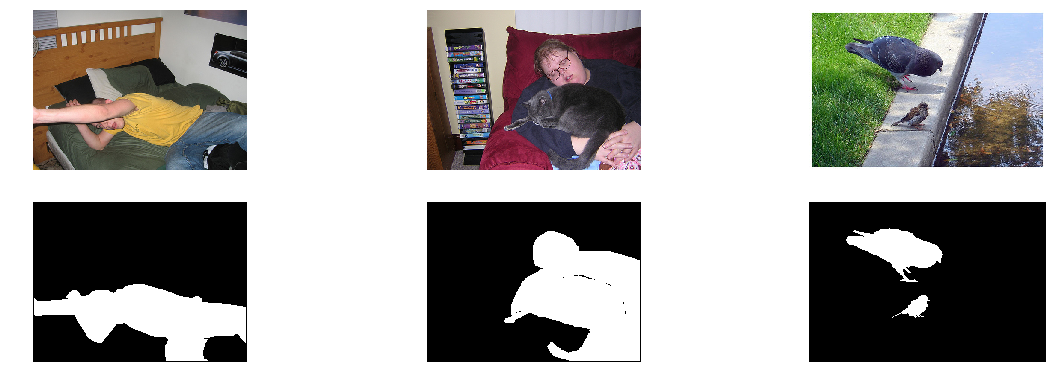

In [422]:
plt.figure(figsize=(20,10))
show_ims.extend(show_labs)
show_ims = [im.squeeze(0) for im in show_ims]
columns = 3
for i, image in enumerate(show_ims):
    if i >=3:
        image = image.squeeze()
    plt.subplot(len(show_ims) / columns + 1, columns, i + 1)
    fig = plt.imshow(image, cmap=pyplot.cm.binary_r)
    plt.axis('off')
plt.show()

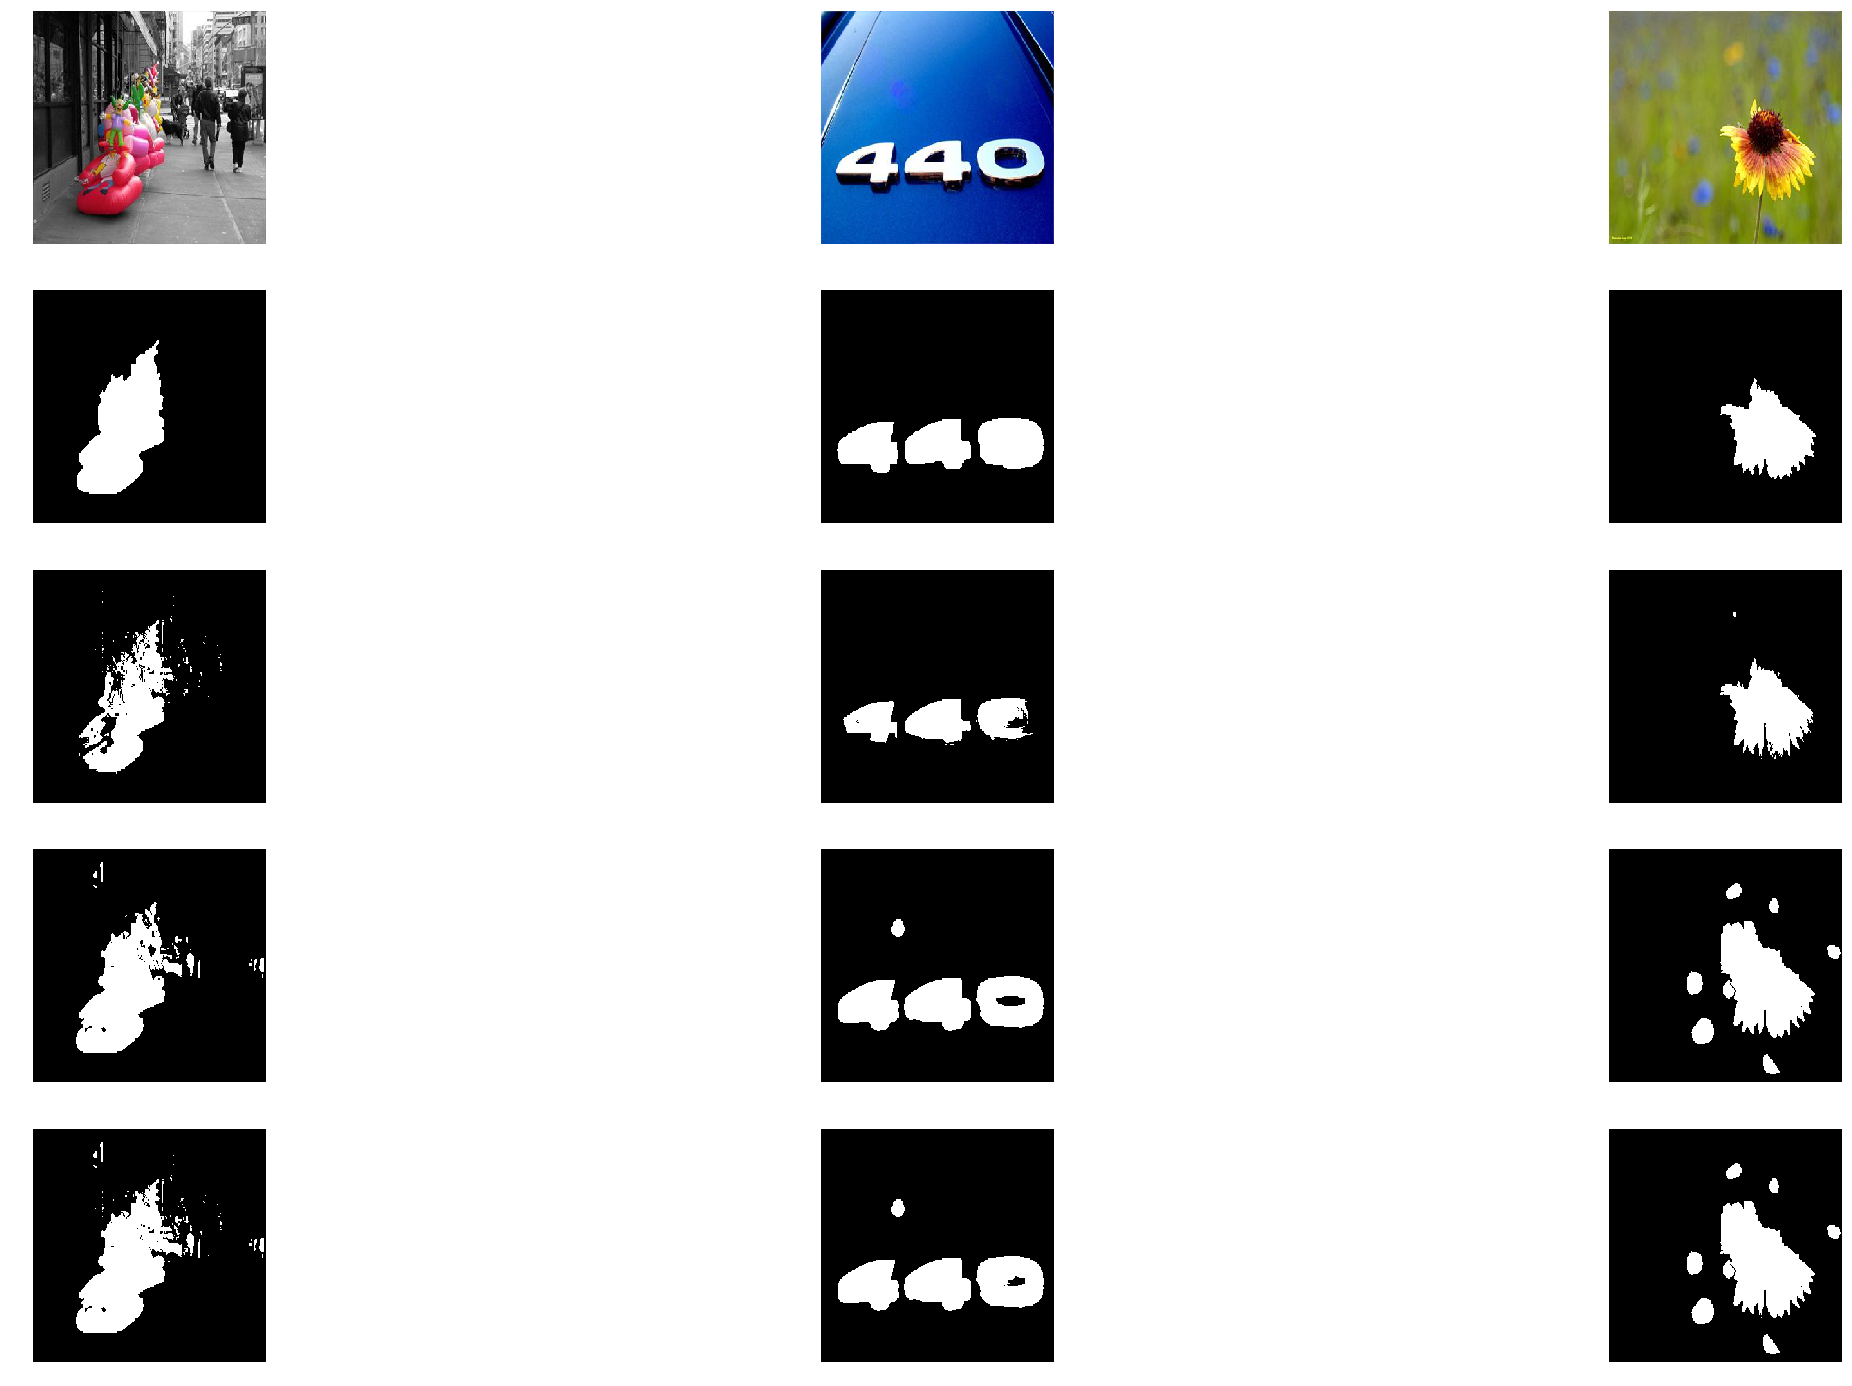

In [428]:
def replace(imname):
    imname = imname.replace('.jpg', '')
    imname = imname.replace('.png', '')
    return imname

all_ims = os.listdir('msra10k')
all_ims = [im for im in all_ims if '.jpg' in im]
mbd_masks = os.listdir('mbd-masks-msra')
rbd_masks = os.listdir('rbd-masks-msra')
all_ims = list(map(replace, all_ims))
mbd_masks = list(map(replace, mbd_masks))
rbd_masks = list(map(replace, rbd_masks))
valid_ims = []
for im in all_ims:
    if (str(im) in mbd_masks) and (str(im) in rbd_masks):
        valid_ims.append(im)
valid_ims.sort()
valid_ims = [im+'.jpg' for im in valid_ims]
idx = np.random.choice(range(len(valid_ims)), size = 3)
chosen = [valid_ims[i] for i in idx]
images = [load_image(os.path.join('msra10k', im)) for im in chosen]
gt = [load_image(os.path.join('msra10k', im.replace('.jpg', '.png'))) for im in chosen]
mbd = [load_image(os.path.join('mbd-masks-msra', im.replace('.jpg', '.png'))) for im in chosen]
rbd = [load_image(os.path.join('rbd-masks-msra', im.replace('.jpg', '.png'))) for im in chosen]
joined = [load_image(os.path.join('sum-masks-msra', im.replace('.jpg', '.png'))) for im in chosen]
images.extend(gt)
images.extend(mbd)
images.extend(rbd)
images.extend(joined)
plt.figure(figsize=(40,30))
#images = [im.squeeze(0) for im in images]
columns = 3
for i, image in enumerate(images):
    if i >=3:
        image = image.squeeze()
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    fig = plt.imshow(image, cmap=pyplot.cm.binary_r)
    plt.axis('off')
plt.show()

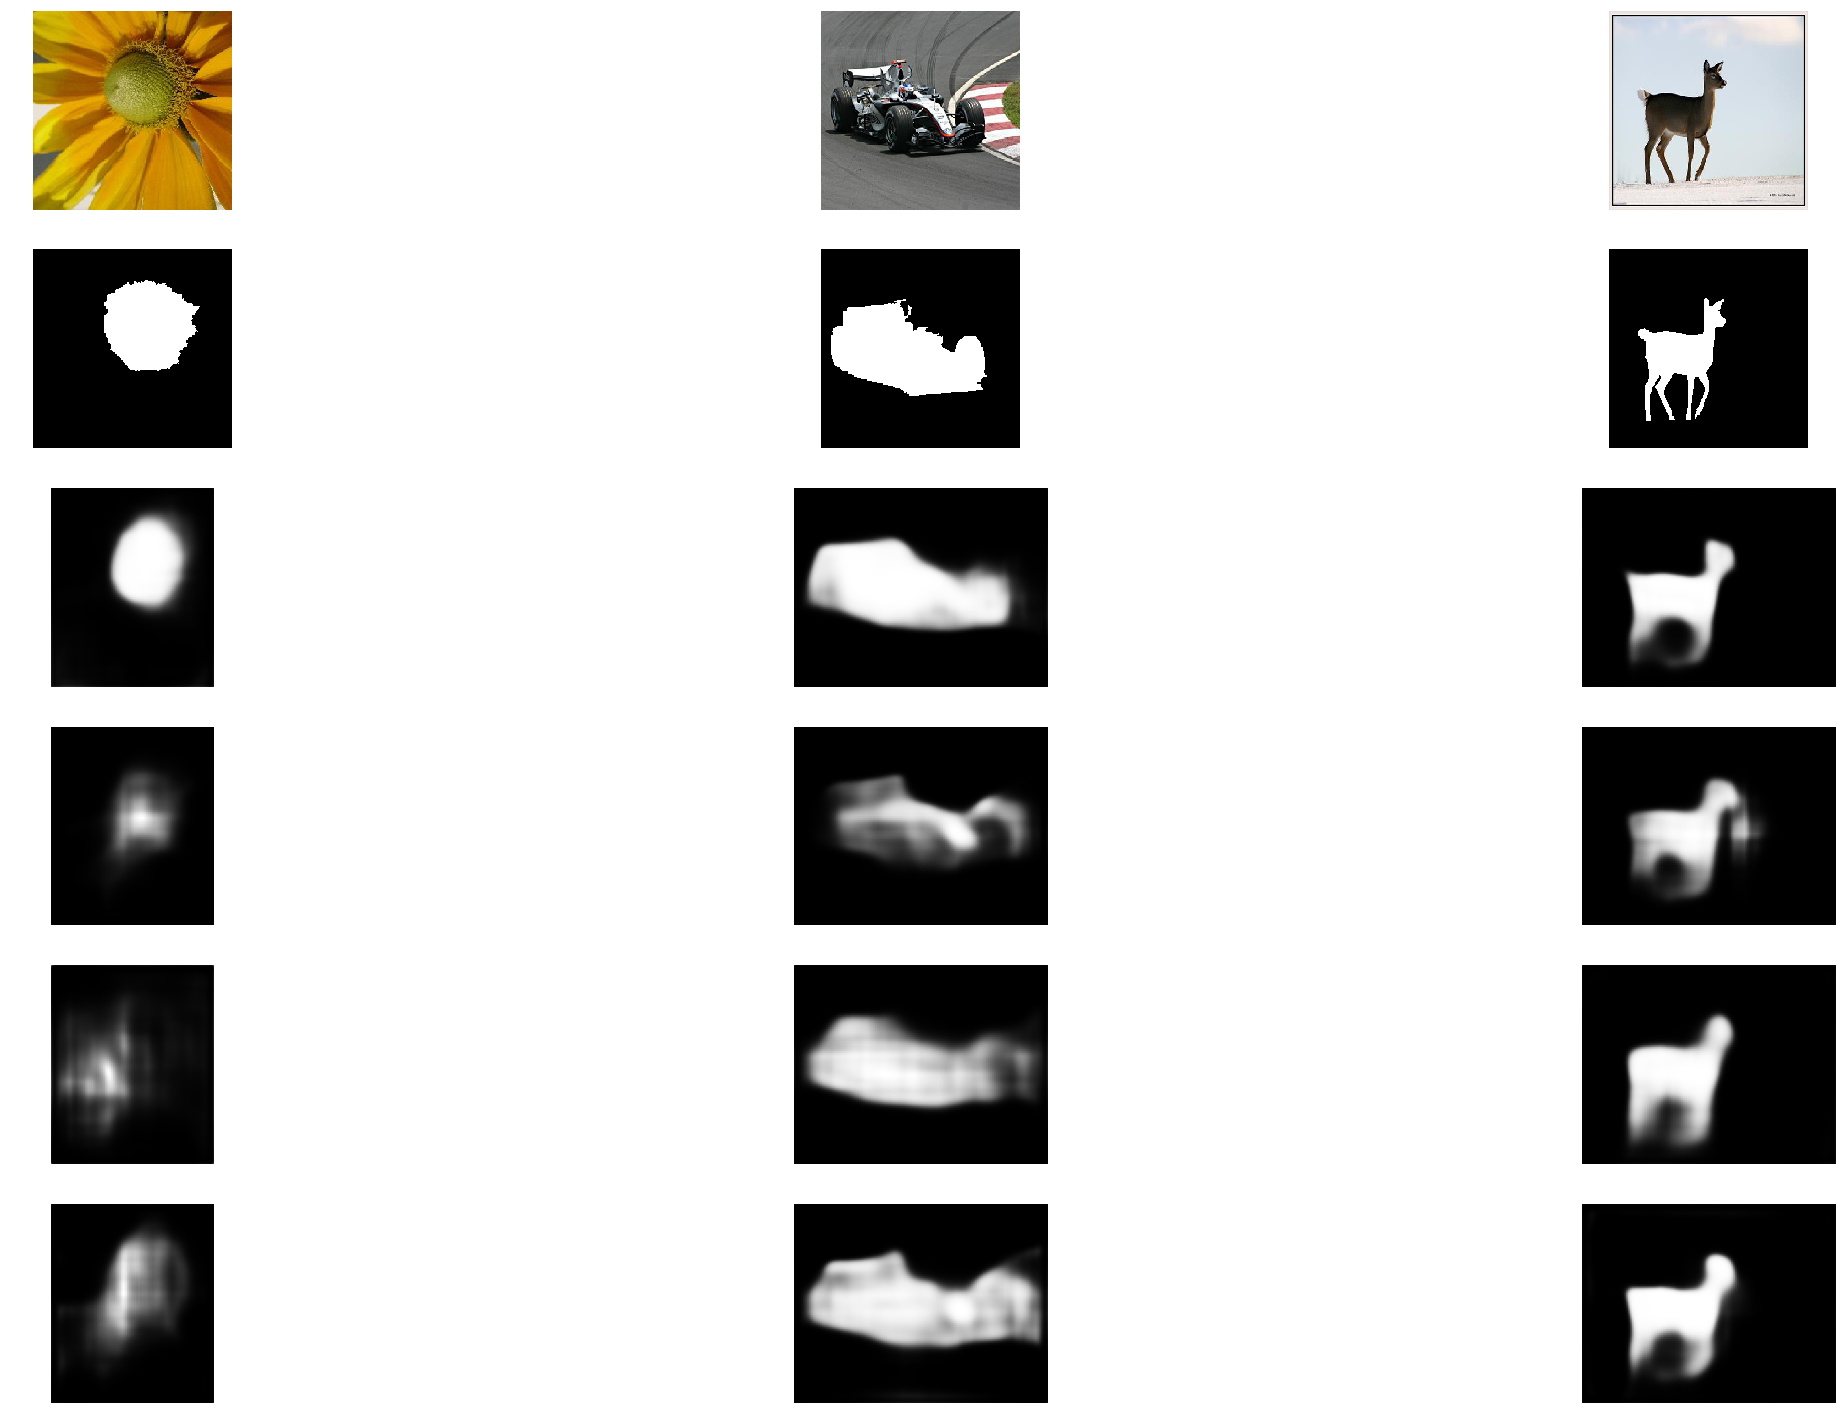

In [434]:
def replace(imname):
    imname = imname.replace('.jpg', '')
    imname = imname.replace('.png', '')
    return imname

def predict_image(image, name):
    if name == 'mbd':
        model.load_weights('checkpoints/model_mbd.15.weights')
    if name == 'gt':
        model.load_weights('checkpoints/model_gt.14.weights')
    if name == 'joined':
        model.load_weights('checkpoints/model_joined.27.weights')
    if name == 'rbd':
        model.load_weights('checkpoints/model_rbd.29.weights')
    image = Image.open(os.path.join('msra10k', image))
    image = np.asarray(image)/255
    image = image[np.newaxis, ...]
    pred = model.predict(image)
    pred = pred.squeeze()
    return pred

all_ims = os.listdir('msra10k')
all_ims = [im for im in all_ims if '.jpg' in im]
mbd_masks = os.listdir('mbd-masks-msra')
rbd_masks = os.listdir('rbd-masks-msra')
all_ims = list(map(replace, all_ims))
mbd_masks = list(map(replace, mbd_masks))
rbd_masks = list(map(replace, rbd_masks))
valid_ims = []
for im in all_ims:
    if (str(im) in mbd_masks) and (str(im) in rbd_masks):
        valid_ims.append(im)
valid_ims.sort()
valid_ims = [im+'.jpg' for im in valid_ims]
idx = np.random.choice(range(len(valid_ims)), size = 3)
chosen = [valid_ims[i] for i in idx]
images = [load_image(os.path.join('msra10k', im)) for im in chosen]
gt = [load_image(os.path.join('msra10k', im.replace('.jpg', '.png'))) for im in chosen]
net_gt = [predict_image(im, 'gt') for im in chosen]
mbd = [predict_image(im, 'mbd') for im in chosen]
rbd = [predict_image(im, 'rbd') for im in chosen]
joined = [predict_image(im, 'joined') for im in chosen]
images.extend(gt)
images.extend(net_gt)
images.extend(mbd)
images.extend(rbd)
images.extend(joined)
plt.figure(figsize=(40,30))
#images = [im.squeeze(0) for im in images]
columns = 3
for i, image in enumerate(images):
    if i >=3:
        image = image.squeeze()
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    fig = plt.imshow(image, cmap=pyplot.cm.binary_r)
    plt.axis('off')
plt.show()

In [ ]:
def predict_image(image):
    pred = model.predict(image)
    pred = pred.squeeze()
    return pred

In [ ]:
idx = np.random.choice(range(len(ecssd_imgs)), 3)
show_ims = [ecssd_imgs[i] for i in idx]
show_labs = [ecssd_labs[i] for i in idx]
plt.figure(figsize=(20,10))
show_ims.extend(show_labs)
show_ims = [im.squeeze(0) for im in show_ims]
columns = 3
for i, image in enumerate(show_ims):
    if i >=3:
        image = image.squeeze()
    plt.subplot(len(show_ims) / columns + 1, columns, i + 1)
    fig = plt.imshow(image, cmap=pyplot.cm.binary_r)
    plt.axis('off')
plt.show()